In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from causalml.inference.meta import BaseSClassifier, BaseTClassifier
from causalml.inference.meta import BaseXClassifier, BaseRClassifier
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklift.viz import plot_qini_curve
from sklift.metrics import qini_auc_score 
from IPython.display import Image
warnings.filterwarnings('ignore')

%matplotlib inline

Failed to import duecredit due to No module named 'duecredit'


In [2]:
# Подгружаем датасет
data = pd.read_csv('data/criteo-uplift-v2.1.csv')

#### EDA

Датасет: Французское рекламное агентство Criteo предоставило данные о показах рекламы и отклике пользователей на рекламные предложения.

Представляет собой набор наблюдений:
- f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11  
признаки, float
- treatment  
treatment group (1 = treated, 0 = control)
- conversion  
конверсия для этого пользователя (бинарное значение)
- visit  
посещение (бинарное значение)
- exposure  
эффект воздействия (двоичное значение)

В качестве целевой переменной, в зависимости от задачи, можно выбрать либо conversion, либо visit. Мы остановимся на conversion.

In [3]:
# Посмотрим на данные
data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [5]:
data.isna().sum()

f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

В нашем случае, датасет содержит 16 колонок, 13,98 млн наблюдений. NaN - отсутствуют.

В виду ограниченных вычислительных ресурсов урежем выборку до 2 млн наблюдений. Поделим поровну treatment group.

In [6]:
cnt = 1000000
data = pd.concat([data[data.treatment == 0].head(cnt), data[data.treatment == 1].head(cnt)], ignore_index=True)

In [7]:
# Оценим сбалансированность
for column in ['treatment', 'conversion', 'visit']:
    print(data[column].value_counts())

1    1000000
0    1000000
Name: treatment, dtype: int64
0    1991842
1       8158
Name: conversion, dtype: int64
0    1951975
1      48025
Name: visit, dtype: int64


In [8]:
# Определим переменные по признакам
feature_cols = [f'f{x}' for x in range(0,12)]
treatment_col = 'treatment'
target_col = 'conversion'

In [9]:
pd.crosstab(data[treatment_col], data[target_col], normalize='index')

conversion,0,1
treatment,,
0,0.996598,0.003402
1,0.995244,0.004756


#### Опишем Target Class

**Target Class Declaration**
- Control Non-Responders(CN)  
*Customers that don't make a purchase without an offer (value = 0)*
- Control Responders(CR)  
*Customers that make a purchase without an offer (value = 1)*
- Treatment Non-Responders(TN)  
*Customer that don't make a purchase and receive an offer (value = 2)*
- Treatment Responders(TR)  
*Customers that make a purchase and receive an offer (value = 3)*

In [10]:
def declare_tc(df:pd.DataFrame, treatment_col, target_col):
    """ Определение target class """
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df[treatment_col] == 0) & (df[target_col] != 0),'target_class'] = 1 
    #TN:
    df.loc[(df[treatment_col] != 0) & (df[target_col] == 0),'target_class'] = 2 
    #TR:
    df.loc[(df[treatment_col] != 0) & (df[target_col] != 0),'target_class'] = 3 
    return df

In [11]:
data = declare_tc(data, treatment_col, target_col)
data.target_class.value_counts()

0    996598
2    995244
3      4756
1      3402
Name: target_class, dtype: int64

В нашей выборке, к группе TR относится 4756 наблюдений

#### Оценка качества моделей

In [12]:
# Для сравнения алгоритмов будем фиксировать результат в dict
result_dict = {}

In [13]:
def get_metrics(df):
    """ Функция отрисовывает кривую Qini Curve и отображает значение AUC """
    plot_qini_curve(df[target_col], df['uplift_score'], df[treatment_col], perfect=True)
    
    # AUQC = area under Qini curve = Qini coefficient
    auqc = qini_auc_score(df_test[target_col], df_test['uplift_score'], df_test[treatment_col]) 
    return f'{auqc:.4f}'

#### Разделение данных

In [14]:
# Разделим датасет на обучающую и валиадационную выборки
df_train, df_test = train_test_split(data, stratify=data[[treatment_col, target_col]], random_state=42, shuffle=True, test_size=0.3)

#### S-learner  

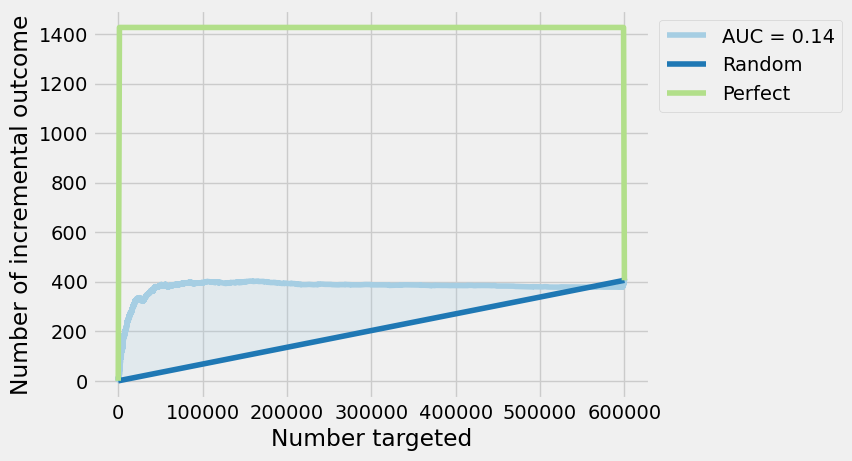

In [15]:
# Создадим базовый S-learner, классификатор CatBoost
s_learner = BaseSClassifier(learner=CatBoostClassifier(random_seed=42, verbose=0))

s_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Посмотрим на метрику модели
result_dict['S-learner-CatBoost'] = get_metrics(df_test)

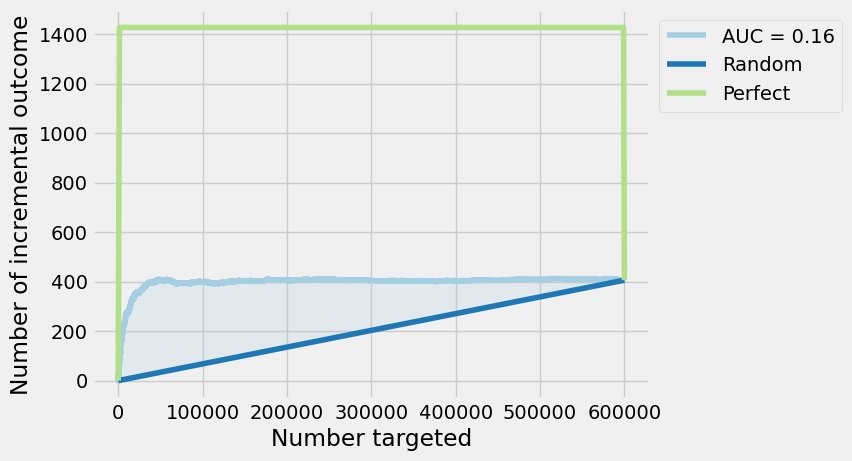

In [16]:
# Построим S-learner с логистической регрессией
from sklearn.linear_model import LogisticRegression

s_learner = BaseSClassifier(learner=LogisticRegression(verbose=0))
s_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Посмотрим на метрику модели
result_dict['S-learner-LR'] = get_metrics(df_test)

Вполне неплохой результат

#### T-learner

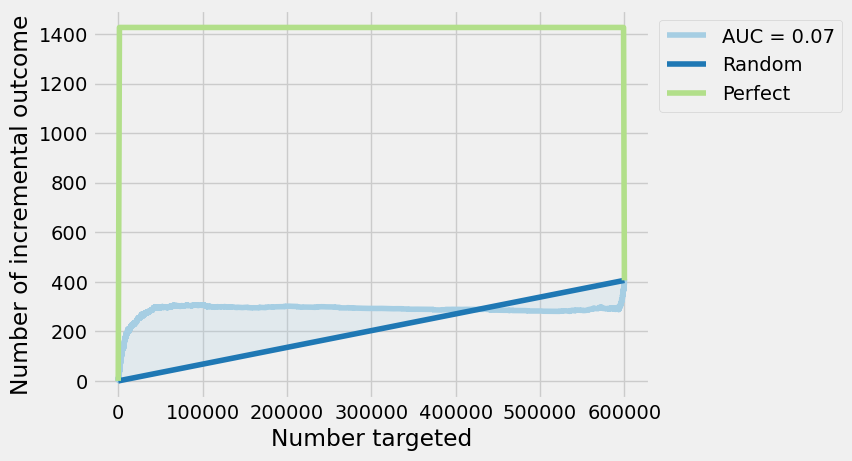

In [17]:
# Создадим базовый T-learner
t_learner = BaseTClassifier(learner=CatBoostClassifier(random_seed=13, verbose=0))

t_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = t_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Посмотрим на метрику модели
result_dict['T-learner-base'] = get_metrics(df_test)

#### X-learner

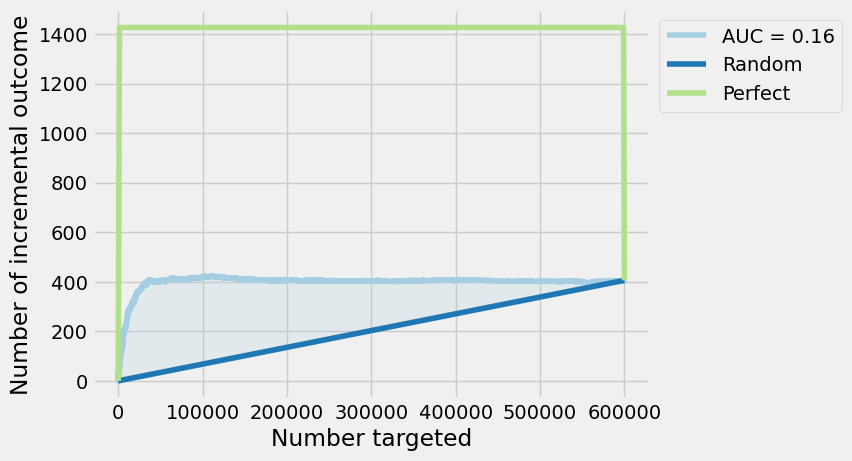

In [18]:
# Создадим базовый X-learner
x_learner = BaseXClassifier(outcome_learner=LogisticRegression(random_state=42),
                           effect_learner=LinearRegression())

x_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = x_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Посмотрим на метрику модели
result_dict['X-learner'] = get_metrics(df_test)

#### R-learner

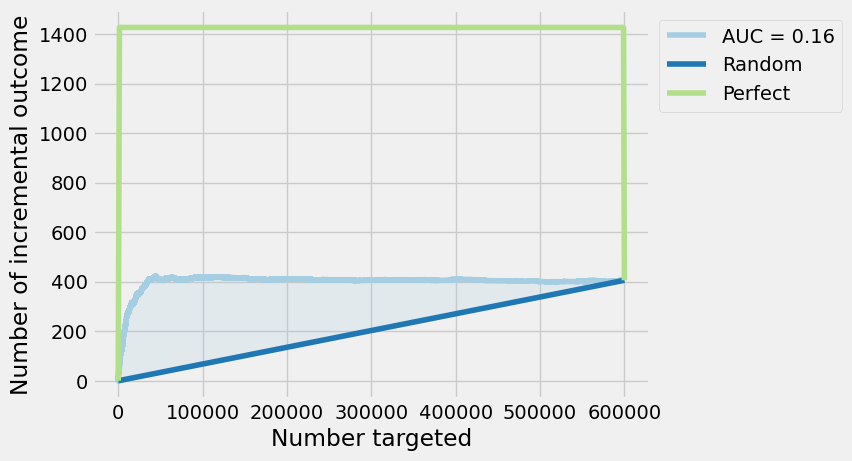

In [19]:
# Создадим базовый R-learner
r_learner = BaseRClassifier(outcome_learner=LogisticRegression(),
                            effect_learner=LinearRegression())

r_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = r_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Посмотрим на метрику модели
result_dict['R-learner'] = get_metrics(df_test)

#### UpliftTree

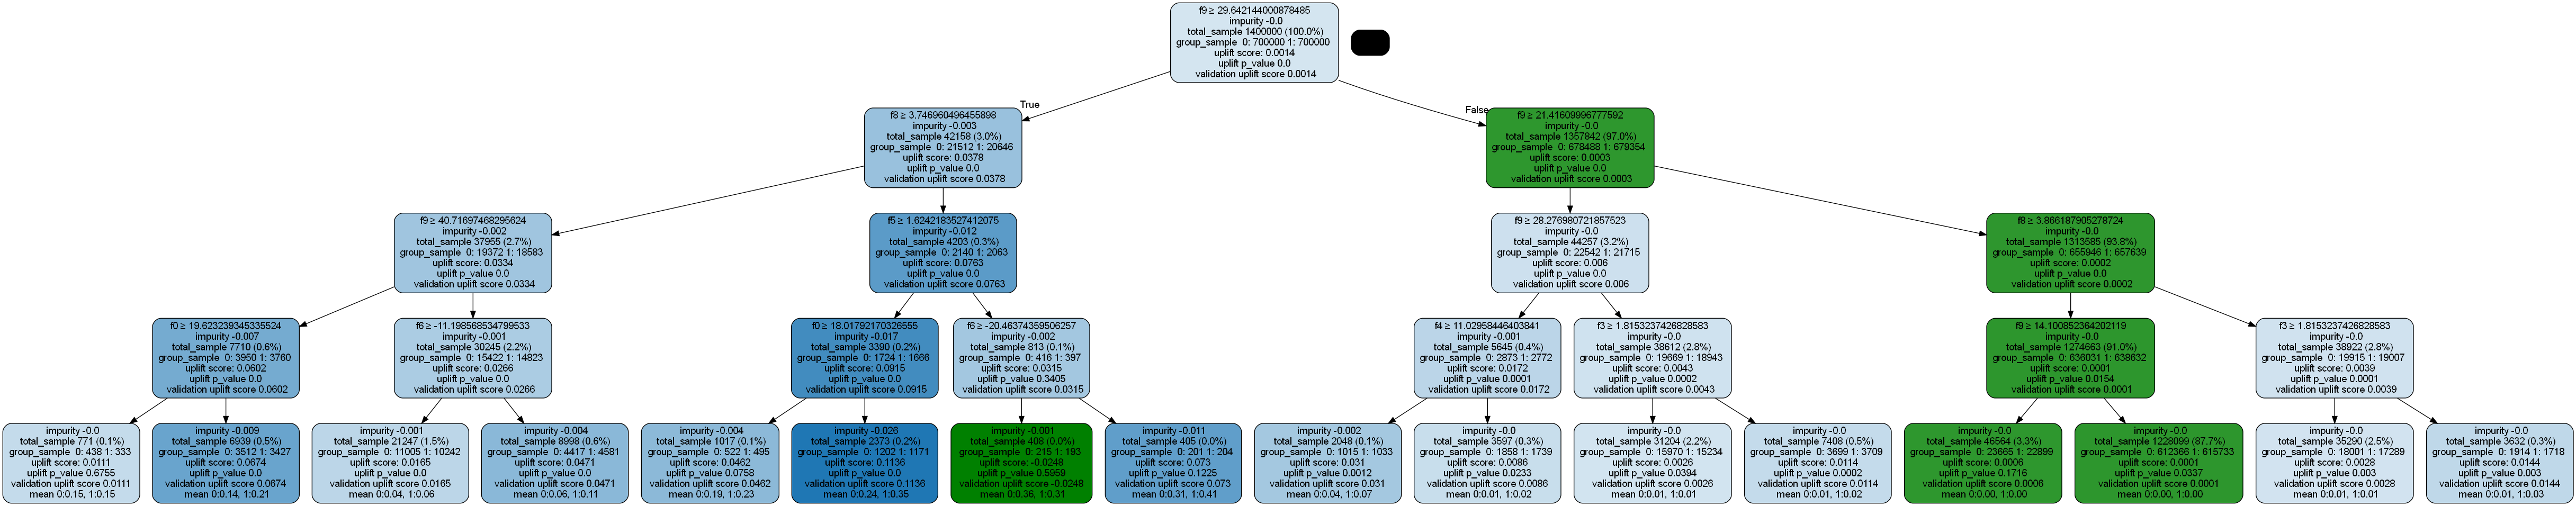

In [20]:
# Построим простейшее дерево
# Учим простое дерево. Обратим внимание, что для деревьев из CausalMl не нужно трансформировать целевые переменные
uplift_model = UpliftTreeClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='ED', control_name='0')

uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_col].apply(str).values,
                 y=df_train[target_col].values)

# Визуализируем дерево
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, feature_cols)
Image(graph.create_png())

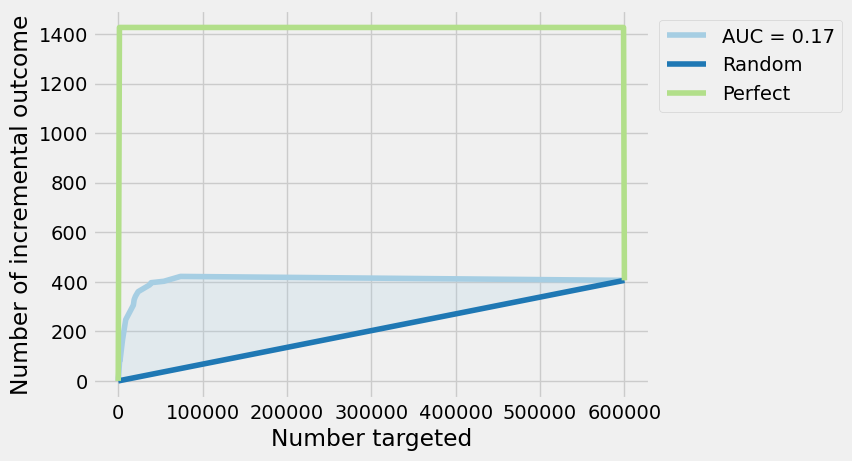

In [21]:
uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Посмотрим на метрику модели
result_dict['UpliftTree'] = get_metrics(df_test)

#### UpliftRandomForest

In [ ]:
# Построим случайный лес
uplift_model = UpliftRandomForestClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='ED', control_name='0')

uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_col].apply(str).values,
                 y=df_train[target_col].values)

uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Посмотрим на метрику модели
result_dict['UpliftRandomForest'] = get_metrics(df_test)

#### Подведем итоги

In [ ]:
sorted(result_dict.items(), key=lambda x: x[1], reverse=True)

Вывод: в данном случае, простое дерево показало лучший результат. Тем не менее, стоит отметить что качество модели может сильно зависеть от сбалансированности признаков. При различном наборе наблюдений стоит перепроверять оценку разных подходов.

Варианты улучшения результата на текущем датасете:
1) Обучить модели на полном датасете (мы использовали урезанный);
2) Добавить полиномиальные признаки;
3) Использовать более сложные предикторы с подбором гиперпараметров.